In [55]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from patsy import dmatrices

import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.set_option('display.max_row',None)

In [56]:
# read and drop non-important columns
data = pd.read_csv('data/geneva.csv')
data.set_index('id',inplace=True)

## Data Cleaning of the Explained Variable: Price

In [57]:
# data cleaning: price, transfer from str to float
data.dropna()
data.dropna(subset=["price"],inplace=True)
data["price"] = data["price"].str.replace(",", "")
data["price"] = data["price"].str.replace("$", "").astype("float")

# Have an Idea of the price datapoints
data.price.describe()

count     2127.000000
mean       175.730606
std        642.915884
min         19.000000
25%         83.000000
50%        115.000000
75%        160.000000
max      25000.000000
Name: price, dtype: float64

In [58]:
# Remove extreme values (3 sigma principle)
priceH = data.price.mean()+3*data.price.std()
priceL = data.price.mean()-3*data.price.std()

outliersH = data.loc[(data.price > priceH)]
outliersL = data.loc[(data.price < priceL)]

print('The outliers above 3 std of the mean have mean and std:')
OutliersH_stats = outliersH['price'].agg(['mean','std'])
display(OutliersH_stats)

print('The outliers below 3 std of the mean have mean and std:')
OutliersL_stats = outliersL['price'].agg(['mean','std'])
display(OutliersL_stats)

data = data.loc[(data.price < priceH) & (data.price > priceL) ]

The outliers above 3 std of the mean have mean and std:


mean    7852.750000
std     7250.051975
Name: price, dtype: float64

The outliers below 3 std of the mean have mean and std:


mean   NaN
std    NaN
Name: price, dtype: float64

In [59]:
# Have an Idea of the price datapoints
data.price.describe()

count    2119.000000
mean      146.747050
std       133.144515
min        19.000000
25%        82.500000
50%       115.000000
75%       160.000000
max      2000.000000
Name: price, dtype: float64

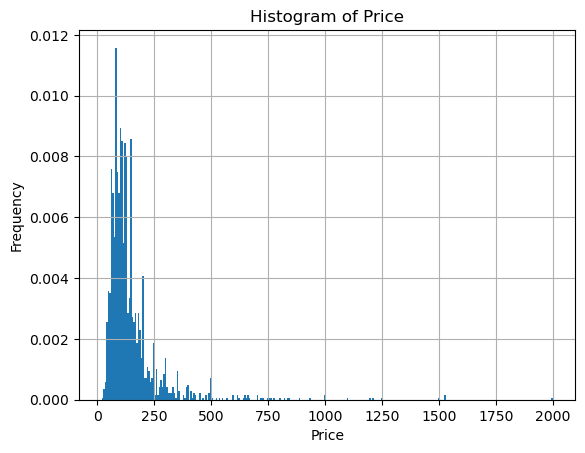

In [60]:
# plot histogram
plt.hist(data['price'], bins=300, density= True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of Price')
plt.show()

# We can see that we still have some outliers but it is important to keep some those that are realistic (in the +/- 3 std range) 
# because they are representative of the real estate market

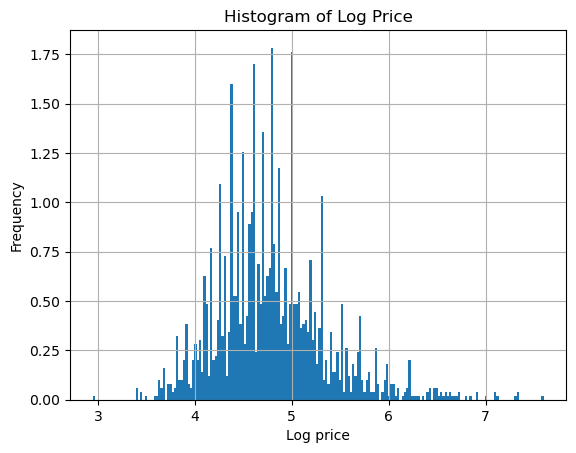

In [61]:
# calculate log price
data["ln_price"] = np.log(data.price)

# plot histogram
plt.hist(data['ln_price'], bins=200, density=True)
plt.xlabel('Log price')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of Log Price')
plt.show()

# Applying the log price allows us to have a distribution that is a bit more normal with thinner tails (more homoskedastic)

## Feature Selection

In [62]:
# See all of the features
original_data_columns_name = data.columns.tolist()
print(original_data_columns_name)
print(f'We have in total {len(original_data_columns_name)} columns')

['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_36

In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
scrape_id,2119.0,2.023123e+13,1.484725e-01,2.023123e+13,2.023123e+13,2.023123e+13,2.023123e+13,2.023123e+13
description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,2119.0,1.585419e+08,1.749969e+08,6.783700e+04,1.488448e+07,6.880790e+07,2.737343e+08,5.522256e+08
host_listings_count,2119.0,1.220623e+01,3.167128e+01,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,1.940000e+02
host_total_listings_count,2119.0,2.370316e+01,7.276354e+01,1.000000e+00,1.000000e+00,3.000000e+00,7.000000e+00,3.630000e+02
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,2119.0,4.620724e+01,1.954281e-02,4.614146e+01,4.619791e+01,4.620556e+01,4.621253e+01,4.635168e+01
longitude,2119.0,6.144051e+00,2.747076e-02,5.972910e+00,6.132737e+00,6.144570e+00,6.156660e+00,6.273080e+00
accommodates,2119.0,2.649835e+00,1.515139e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.500000e+01
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
features_to_remove = ['scrape_id','description', 'host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_neighbourhood',
                      'host_picture_url','neighborhood_overview','picture_url','neighbourhood_group_cleansed','last_scraped', 'listing_url','source',
                      'name','license','minimum_minimum_nights','maximum_minimum_nights','maximum_nights','minimum_maximum_nights','maximum_maximum_nights',
                      'first_review','calendar_updated','calendar_last_scraped','last_review','amenities','bedrooms','bathrooms','latitude', 'longitude']

data.drop(features_to_remove,axis = 1,inplace = True)

## additional Info
# We kept: neighborhoods, 'minimum_nights_avg_ntm','maximum_nights_avg_ntm', host_verifications
# Before: features_to_remove = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','neighbourhood_group_cleansed','amenities','minimum_minimum_nights','maximum_minimum_nights','host_verifications','maximum_nights','first_review','last_review','bedrooms','bathrooms',
#'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','calendar_last_scraped','license']

In [65]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,2119.0,12.206229,31.671285,1.000000,1.00000,2.000000,5.000000,194.000000
host_total_listings_count,2119.0,23.703162,72.763540,1.000000,1.00000,3.000000,7.000000,363.000000
accommodates,2119.0,2.649835,1.515139,1.000000,2.00000,2.000000,4.000000,15.000000
beds,2075.0,1.597108,1.044613,1.000000,1.00000,1.000000,2.000000,12.000000
price,2119.0,146.747050,133.144515,19.000000,82.50000,115.000000,160.000000,2000.000000
minimum_nights,2119.0,7.739500,39.159743,1.000000,1.00000,2.000000,5.000000,1100.000000
minimum_nights_avg_ntm,2119.0,7.711609,38.389093,1.000000,1.00000,2.000000,5.000000,1100.000000
maximum_nights_avg_ntm,2119.0,615.097593,468.525499,1.000000,120.00000,365.000000,1125.000000,1125.000000
availability_30,2119.0,14.330345,11.909336,0.000000,0.00000,15.000000,27.000000,30.000000
availability_60,2119.0,30.808400,23.738585,0.000000,4.00000,31.000000,56.000000,60.000000


### Neighborhoods

neighbourhood_cleansed
Commune de Genève     1513
Vernier                 75
Grand-Saconnex          66
Carouge                 57
Thônex                  44
Lancy                   42
Chêne-Bougeries         42
Meyrin                  38
Versoix                 38
Cologny                 23
Chêne-Bourg             21
Veyrier                 19
Pregny-Chambésy         15
Plan-les-Ouates         14
Bellevue                14
Onex                    13
Collonge-Bellerive      11
Bernex                   9
Vandoeuvres              8
Genthod                  6
Anières                  5
Meinier                  5
Hermance                 4
Troinex                  4
Corsier                  4
Bardonnex                3
Avully                   3
Puplinge                 3
Satigny                  3
Collex-Bossy             2
Presinge                 2
Confignon                2
Céligny                  2
Soral                    2
Chancy                   2
Russin                   1
Gy   

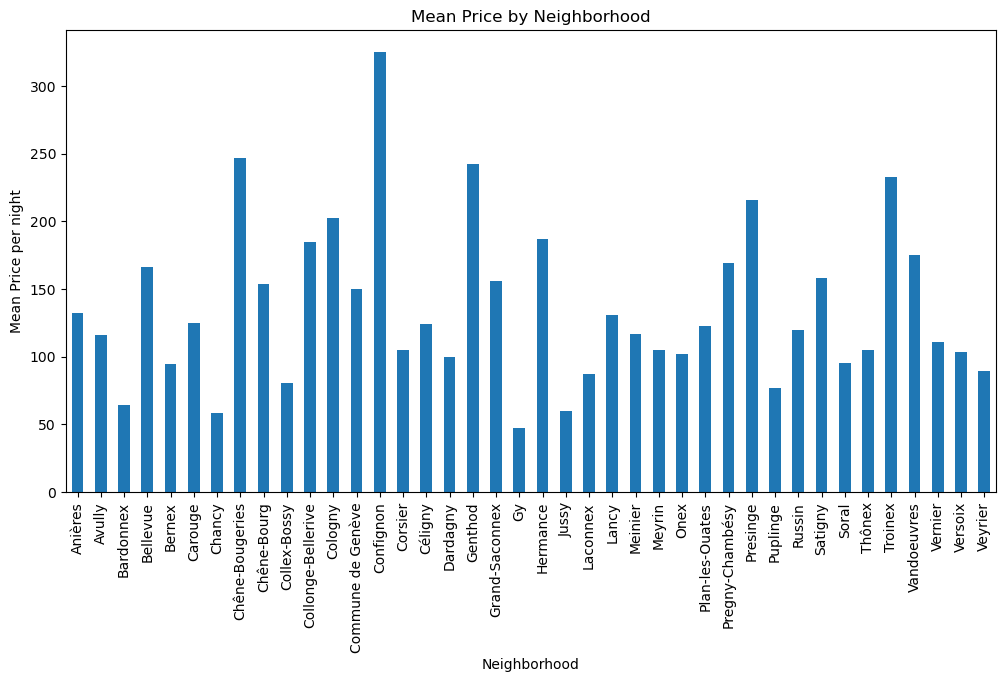

In [66]:
# Group dataset by neighborhood
grouped = data.groupby('neighbourhood_cleansed')
print(data.neighbourhood_cleansed.value_counts())

data.dropna(subset=["neighbourhood_cleansed"],inplace=True)

# Add a One hot Encoder for the neighborhoods

# Calculate the mean price for each neighborhood
mean_price = grouped['price'].mean()

# Plot the mean prices
plt.figure(figsize=(12, 6))
mean_price.plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price per night')
plt.title('Mean Price by Neighborhood')
plt.show()


# One-hot encode the 'neighbourhood_cleansed' column
one_hot_encoded = pd.get_dummies(data['neighbourhood_cleansed'])

# Concatenate the one-hot encoded columns with the original dataframe
data = pd.concat([data, one_hot_encoded], axis=1)

data_neighborhood_name = data.neighbourhood_cleansed.unique().tolist()
neighborhood_string = ' + '.join([name.replace('-', '_') for name in data_neighborhood_name])

new_column_names = [col.replace('-', '_') for col in data.columns]
data.columns = new_column_names

# Drop the original 'neighbourhood_cleansed' column
data.drop('neighbourhood_cleansed', axis=1, inplace=True)




### Room Type

In [67]:
# Unerstanding of the different values of Room Type
print(f'{data.room_type.value_counts()}')

data.dropna(subset=["room_type"],inplace=True)


room_type
Entire home/apt    1463
Private room        643
Shared room           9
Hotel room            4
Name: count, dtype: int64


In [68]:
# Modify the Room Type column to an Entire Home column
data.rename(columns={'room_type': 'Entire_room'}, inplace=True)
data.Entire_room = [1 if x == "Entire home/apt" else 0 for x in data.Entire_room]
print(data.Entire_room.value_counts())
 
simp_reg_entire_rooms = smf.ols('ln_price ~ Entire_room', data=data).fit()
simp_reg_entire_rooms.summary()


Entire_room
1    1463
0     656
Name: count, dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     551.6
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.37e-108
Time:                        22:57:04   Log-Likelihood:                -1567.0
No. Observations:                2119   AIC:                             3138.
Df Residuals:                    2117   BIC:                             3149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.4050      0.020    222.469      0.000       4.366       4.444
Entire_room     0.5597      0.024     23.486      0.000       0.513       0.606
==============================================================================
Omnibus:                      488.784   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1255.464
Skew:                           1.230   Prob(JB):                    2.40e-273
Kurtosis:                       5.858   Cond. No.                         3.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Beds

beds
12       1
9        1
10       1
7        3
8        3
6       14
5       29
4       60
3      161
2      484
1     1318
Name: count, dtype: int64


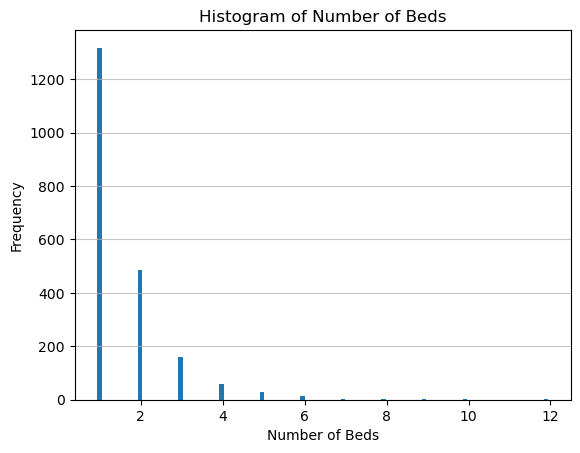

In [69]:
data.dropna(subset=["beds"],inplace=True)

print(data['beds'].astype(int).value_counts().sort_values())

# Plot histogram
plt.hist(data['beds'], bins=100, align='left')
plt.xlabel('Number of Beds')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Beds')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [70]:
data.loc[data['beds']>10,'beds'] = 10 # winsorize extreme value becuase extremely rare and not common
data.beds.describe()

count    2075.000000
mean        1.596145
std         1.035896
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: beds, dtype: float64

In [71]:
simp_reg_beds = smf.ols(formula="ln_price ~ beds", data=data).fit()
simp_reg_beds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     565.2
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.12e-110
Time:                        22:57:04   Log-Likelihood:                -1528.1
No. Observations:                2075   AIC:                             3060.
Df Residuals:                    2073   BIC:                             3071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3851      0.020    215.046      0.000       4.345       4.425
beds           0.2548      0.011     23.774      0.000       0.234       0.276
==============================================================================
Omnibus:                      357.259   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              972.173
Skew:                           0.911   Prob(JB):                    7.86e-212
Kurtosis:                       5.815   Cond. No.                         4.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bathrooms:

In [72]:
data.dropna(subset=["bathrooms_text"],inplace=True)

data.bathrooms_text.value_counts()


bathrooms_text
1 bath              1205
1 shared bath        241
1.5 baths            200
2 baths              115
1 private bath       105
1.5 shared baths      80
2.5 baths             56
2 shared baths        23
3 baths               16
Half-bath             11
3.5 baths              5
4 baths                4
2.5 shared baths       3
4.5 baths              3
Shared half-bath       2
0 shared baths         1
0 baths                1
3 shared baths         1
6.5 baths              1
Name: count, dtype: int64

In [73]:
# transfer into numerical
tmp = data.bathrooms_text
tmp = tmp.replace({'Shared half-bath':0.5, 'Half-bath':0.5})
tmp = tmp.str.extractall(r'(\d+(?:\.\d+)?)')
tmp.columns =['n_bath']
tmp = tmp.reset_index(level=1).drop('match',axis=1)
data = data.merge(tmp,left_index=True,right_index=True,how = 'outer', validate='one_to_one')
data.n_bath = data.n_bath.astype('float')
data.n_bath.value_counts().sort_index()

n_bath
0.0       2
1.0    1551
1.5     280
2.0     138
2.5      59
3.0      17
3.5       5
4.0       4
4.5       3
6.5       1
Name: count, dtype: int64

In [74]:
data.loc[data['n_bath']>10,'n_bath'] = 10 # winsorize extreme value
data.n_bath.describe()

count    2060.000000
mean        1.213107
std         0.468247
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.500000
Name: n_bath, dtype: float64

In [75]:
simp_reg_bath = smf.ols(formula="ln_price ~ n_bath", data=data).fit()
simp_reg_bath.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     343.0
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           5.93e-71
Time:                        22:57:05   Log-Likelihood:                -1603.4
No. Observations:                2060   AIC:                             3211.
Df Residuals:                    2058   BIC:                             3222.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2383      0.032    131.355      0.000       4.175       4.302
n_bath         0.4596      0.025     18.521      0.000       0.411       0.508
==============================================================================
Omnibus:                      160.478   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.053
Skew:                           0.556   Prob(JB):                     3.43e-62
Kurtosis:                       4.435   Cond. No.                         5.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Review Scores Rating

In [76]:
data.dropna(subset=["review_scores_rating"],inplace=True)

data.review_scores_rating.describe()

count    1672.000000
mean        4.701968
std         0.458594
min         1.000000
25%         4.597500
50%         4.830000
75%         5.000000
max         5.000000
Name: review_scores_rating, dtype: float64

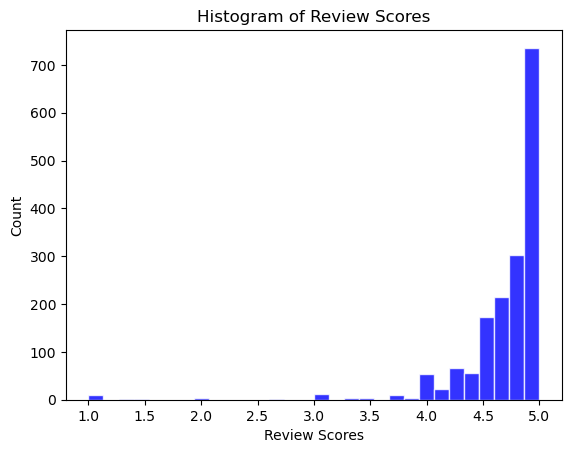

In [77]:
# plot histogram
plt.hist(data['review_scores_rating'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.title('Histogram of Review Scores')
plt.show()

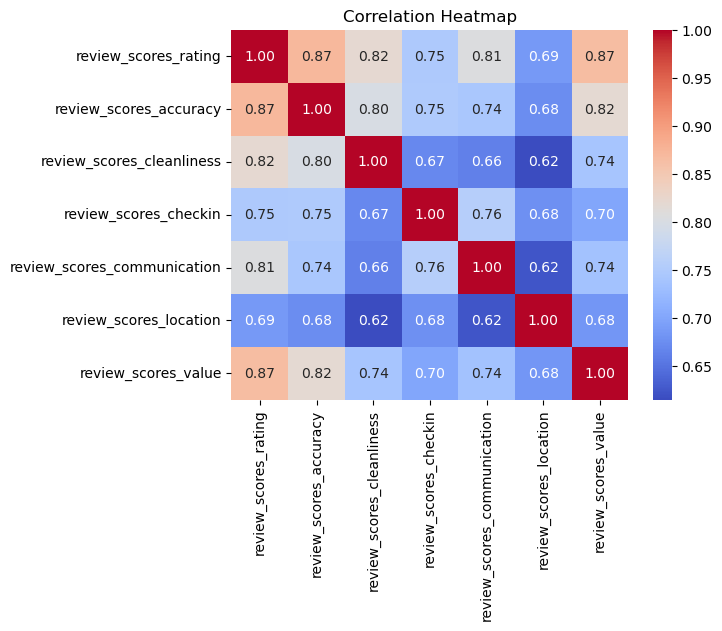

review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value


In [78]:
rscores = data.loc[:,[x for x in data.columns if 'review_scores' in x]]
correlation_matrix = rscores.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

list_review_names = [x for x in data.columns if 'review_scores' in x]
review_name_string = ' + '.join(list_review_names)
print(review_name_string)

In [79]:
simp_reg_review_score_rating = smf.ols(formula="ln_price ~ review_scores_rating", data=data).fit()
simp_reg_review_score_rating.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06386
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.801
Time:                        22:57:06   Log-Likelihood:                -1361.0
No. Observations:                1672   AIC:                             2726.
Df Residuals:                    1670   BIC:                             2737.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.8026      0.138     34.875      0.000       4.532       5.073
review_scores_rating    -0.0074      0.029     -0.253      0.801      -0.065       0.050
==============================================================================
Omnibus:                      171.423   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.447
Skew:                           0.736   Prob(JB):                     5.10e-59
Kurtosis:                       4.298   Cond. No.                         50.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
data.dropna(subset=["review_scores_location"],inplace=True)

simp_reg_review_score_location = smf.ols(formula="ln_price ~ review_scores_location", data=data).fit()
simp_reg_review_score_location.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.497
Date:                Tue, 05 Mar 2024   Prob (F-statistic):             0.0192
Time:                        22:57:06   Log-Likelihood:                -1357.0
No. Observations:                1671   AIC:                             2718.
Df Residuals:                    1669   BIC:                             2729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.3691      0.171     25.580      0.000       4.034       4.704
review_scores_location     0.0836      0.036      2.345      0.019       0.014       0.154
==============================================================================
Omnibus:                      173.775   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.464
Skew:                           0.744   Prob(JB):                     6.84e-60
Kurtosis:                       4.303   Cond. No.                         64.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
reg_review_score = smf.ols(formula="ln_price ~ review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value", data=data).fit()
reg_review_score.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.978
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           1.37e-05
Time:                        22:57:06   Log-Likelihood:                -1342.4
No. Observations:                1671   AIC:                             2701.
Df Residuals:                    1663   BIC:                             2744.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4554      0.188     23.719      0.000       4.087       4.824
review_scores_rating            0.1394      0.081      1.730      0.084      -0.019       0.297
review_scores_accuracy         -0.0106      0.069     -0.154      0.878      -0.146       0.124
review_scores_cleanliness       0.0247      0.052      0.476      0.634      -0.077       0.126
review_scores_checkin          -0.0404      0.061     -0.667      0.505      -0.159       0.078
review_scores_communication    -0.0641      0.056     -1.141      0.254      -0.174       0.046
review_scores_location          0.2432      0.053      4.575      0.000       0.139       0.347
review_scores_value            -0.2332      0.056     -4.157      0.000      -0.343      -0.123
==============================================================================
Omnibus:                      167.035   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.260
Skew:                           0.727   Prob(JB):                     8.31e-57
Kurtosis:                       4.264   Cond. No.                         181.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Max/Min Nights

In [82]:
data.dropna(subset=["minimum_nights"],inplace=True)

data.minimum_nights.describe()

count    1671.000000
mean        7.012567
std        39.933363
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1100.000000
Name: minimum_nights, dtype: float64

In [83]:
# Remove extreme values (3 sigma principle)
minimum_nightsH = data.minimum_nights.mean()+3*data.minimum_nights.std()
minimum_nightsL = data.minimum_nights.mean()-3*data.minimum_nights.std()

outliers_nightsH = data.loc[(data.minimum_nights > minimum_nightsH)]
outliers_nightsL = data.loc[(data.minimum_nights < minimum_nightsL)]

print('The outliers above 3 std of the mean have mean and std:')
Outliers_nightsH_stats = outliers_nightsH['minimum_nights'].agg(['mean','std'])
display(OutliersH_stats)

print('The outliers below 3 std of the mean have mean and std:')
Outliers_nightsL_stats = outliers_nightsL['minimum_nights'].agg(['mean','std'])
display(OutliersL_stats)

data = data.loc[(data.minimum_nights < minimum_nightsH) & (data.minimum_nights > minimum_nightsL) ] # remove extreme value
data.minimum_nights.describe()

The outliers above 3 std of the mean have mean and std:


mean    7852.750000
std     7250.051975
Name: price, dtype: float64

The outliers below 3 std of the mean have mean and std:


mean   NaN
std    NaN
Name: price, dtype: float64

count    1667.000000
mean        5.335333
std        11.672799
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       120.000000
Name: minimum_nights, dtype: float64

In [84]:
simp_reg_min_nights = smf.ols(formula="ln_price ~ minimum_nights", data=data).fit()
simp_reg_min_nights.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.251
Date:                Tue, 05 Mar 2024   Prob (F-statistic):             0.0125
Time:                        22:57:06   Log-Likelihood:                -1354.4
No. Observations:                1667   AIC:                             2713.
Df Residuals:                    1665   BIC:                             2724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.7834      0.015    325.543      0.000       4.755       4.812
minimum_nights    -0.0029      0.001     -2.500      0.013      -0.005      -0.001
==============================================================================
Omnibus:                      170.505   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.178
Skew:                           0.735   Prob(JB):                     9.62e-59
Kurtosis:                       4.299   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Host is Superhost:

In [85]:
data.dropna(subset=["host_is_superhost"],inplace=True)

data.host_is_superhost = [1 if x == "t" else 0 for x in data.host_is_superhost]
print(data.host_is_superhost.value_counts())


host_is_superhost
0    1220
1     424
Name: count, dtype: int64


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\49987157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["host_is_superhost"],inplace=True)
C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\49987157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.host_is_superhost = [1 if x == "t" else 0 for x in data.host_is_superhost]


In [86]:
simp_reg_host_superhost = smf.ols(formula="ln_price ~ host_is_superhost", data=data).fit()
simp_reg_host_superhost.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.249
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.264
Time:                        22:57:07   Log-Likelihood:                -1342.8
No. Observations:                1644   AIC:                             2690.
Df Residuals:                    1642   BIC:                             2701.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7811      0.016    304.746      0.000       4.750       4.812
host_is_superhost    -0.0345      0.031     -1.118      0.264      -0.095       0.026
==============================================================================
Omnibus:                      168.156   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.388
Skew:                           0.736   Prob(JB):                     1.05e-57
Kurtosis:                       4.290   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Accomodates

In [87]:
data.dropna(subset=["accommodates"],inplace=True)
data.accommodates.describe()


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\3311307031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["accommodates"],inplace=True)


count    1644.000000
mean        2.665450
std         1.527193
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        15.000000
Name: accommodates, dtype: float64

In [88]:
simp_reg_accomodates = smf.ols(formula="ln_price ~ accommodates", data=data).fit()
simp_reg_accomodates.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     952.8
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          2.28e-165
Time:                        22:57:07   Log-Likelihood:                -967.34
No. Observations:                1644   AIC:                             1939.
Df Residuals:                    1642   BIC:                             1949.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1926      0.022    193.749      0.000       4.150       4.235
accommodates     0.2174      0.007     30.867      0.000       0.204       0.231
==============================================================================
Omnibus:                      164.245   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.599
Skew:                           0.619   Prob(JB):                     9.00e-76
Kurtosis:                       4.874   Cond. No.                         6.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
data['ln_accommodates'] = np.log(data['accommodates'])
simp_reg_ln_accomodates = smf.ols(formula="ln_price ~ ln_accommodates", data=data).fit()
simp_reg_ln_accomodates.summary()


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\3087858467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ln_accommodates'] = np.log(data['accommodates'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     971.3
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          6.64e-168
Time:                        22:57:07   Log-Likelihood:                -961.50
No. Observations:                1644   AIC:                             1927.
Df Residuals:                    1642   BIC:                             1938.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.2298      0.020    206.948      0.000       4.190       4.270
ln_accommodates     0.6436      0.021     31.165      0.000       0.603       0.684
==============================================================================
Omnibus:                      176.557   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.409
Skew:                           0.674   Prob(JB):                     1.10e-77
Kurtosis:                       4.832   Cond. No.                         3.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
#smf.ols(formula="ln_price ~ beds + accommodates + ln_accommodates", data=data).fit().summary()

## Number Of Reviews

In [91]:
data.dropna(subset=["number_of_reviews"],inplace=True)
data.number_of_reviews.describe()

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\1625781087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["number_of_reviews"],inplace=True)


count    1644.000000
mean       33.779805
std        59.596494
min         0.000000
25%         4.000000
50%        12.000000
75%        39.000000
max       748.000000
Name: number_of_reviews, dtype: float64

In [92]:
simp_reg_nbr_reviews = smf.ols(formula="ln_price ~ number_of_reviews", data=data).fit()
simp_reg_nbr_reviews.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.973
Date:                Tue, 05 Mar 2024   Prob (F-statistic):            0.00162
Time:                        22:57:07   Log-Likelihood:                -1338.5
No. Observations:                1644   AIC:                             2681.
Df Residuals:                    1642   BIC:                             2692.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7963      0.015    309.536      0.000       4.766       4.827
number_of_reviews    -0.0007      0.000     -3.158      0.002      -0.001      -0.000
==============================================================================
Omnibus:                      167.758   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.421
Skew:                           0.740   Prob(JB):                     7.66e-57
Kurtosis:                       4.258   Cond. No.                         78.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf
data.ln_number_of_reviews.describe()

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\255443301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf


count    1644.000000
mean        2.465063
std         1.740038
min       -23.025851
25%         1.386294
50%         2.484907
75%         3.663562
max         6.617403
Name: ln_number_of_reviews, dtype: float64

In [94]:
smf.ols(formula="ln_price ~ ln_number_of_reviews+number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.978
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           0.000960
Time:                        22:57:07   Log-Likelihood:                -1336.5
No. Observations:                1644   AIC:                             2679.
Df Residuals:                    1641   BIC:                             2695.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.8328      0.024    201.388      0.000       4.786       4.880
ln_number_of_reviews    -0.0198      0.010     -1.991      0.047      -0.039      -0.000
number_of_reviews       -0.0004      0.000     -1.222      0.222      -0.001       0.000
==============================================================================
Omnibus:                      165.011   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.589
Skew:                           0.733   Prob(JB):                     1.42e-55
Kurtosis:                       4.240   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Availability

id
42515                  58
107438                 57
276025                  6
338682                 25
399388                  0
411058                 53
419631                  0
476344                 50
494701                 33
610738                 55
626512                  9
626831                  0
628495                  0
649023                 41
664917                 34
693976                  0
706264                 21
721025                  0
728403                  0
741176                 60
751882                 59
766186                  0
775934                  0
800449                  6
899661                  1
914760                 45
921964                 60
935428                  4
952342                  0
952395                 34
963950                 49
1163211                 1
1172184                53
1179787                23
1192759                39
1236785                41
1273891                50
1298750                38
1389340  

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\3413961704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["availability_60"],inplace=True)


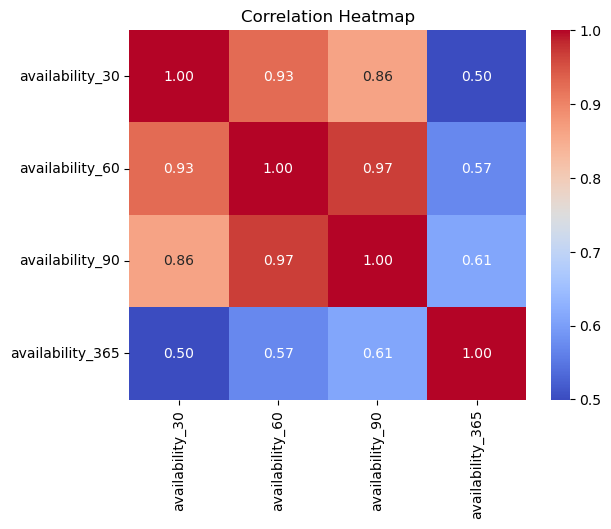

In [95]:
display(data['availability_60'])
data.dropna(subset=["availability_60"],inplace=True)

availability = data.loc[:,[x for x in data.columns if 'availability_' in x]]
correlation_matrix_avail = availability.corr()
sns.heatmap(correlation_matrix_avail, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [96]:
simp_reg_availability = smf.ols(formula="ln_price ~ availability_60", data=data).fit()
simp_reg_availability.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     8.897
Date:                Tue, 05 Mar 2024   Prob (F-statistic):            0.00290
Time:                        22:57:08   Log-Likelihood:                -1339.0
No. Observations:                1644   AIC:                             2682.
Df Residuals:                    1642   BIC:                             2693.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.7215      0.022    217.702      0.000       4.679       4.764
availability_60     0.0017      0.001      2.983      0.003       0.001       0.003
==============================================================================
Omnibus:                      158.580   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.914
Skew:                           0.713   Prob(JB):                     4.85e-53
Kurtosis:                       4.218   Cond. No.                         60.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary of simple regression of Features

In [97]:
models = [ simp_reg_entire_rooms, simp_reg_beds, simp_reg_bath, simp_reg_review_score_rating, 
 simp_reg_review_score_location, reg_review_score, simp_reg_min_nights, simp_reg_host_superhost, simp_reg_accomodates,
 simp_reg_ln_accomodates, simp_reg_nbr_reviews, simp_reg_availability ] # Add more models to this list as needed

model_names = []

for model in models:
    model_name = str(model).split(' ')[1]
    model_names.append(model_name)

# Initialize a list to store the statistics
model_stats = []

for model, name in zip(models, model_names):
    stats = {
        'Model': name,
        'Adj. R²': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
    }
    model_stats.append(stats)

df_stats = pd.DataFrame(model_stats)
print(df_stats)

#print(data.shape[0])
#data.dropna(Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + review_scores_location + number_of_reviews + availability_60 + host_is_superhost"


     Model   Adj. R²          AIC          BIC
0   object  0.206321  3137.945365  3149.262764
1   object  0.213855  3060.188232  3071.463665
2   object  0.142450  3210.739092  3222.000014
3   object -0.000561  2726.003398  2736.846950
4   object  0.002686  2718.003756  2728.846111
5   object  0.016401  2700.846613  2744.216033
6   object  0.003142  2712.802038  2723.639600
7   object  0.000152  2689.693908  2700.503683
8   object  0.366801  1938.682450  1949.492225
9   object  0.371285  1927.000696  1937.810471
10  object  0.005432  2680.989000  2691.798775
11  object  0.004783  2682.060473  2692.870248


## First Model

In [98]:
data=data.dropna(subset=["Entire_room", "accommodates", "beds", "n_bath", "minimum_nights", "review_scores_rating", "review_scores_location", "number_of_reviews", "availability_60", "host_is_superhost"])
formula_string_1 = "ln_price ~ Entire_room + accommodates +minimum_nights+ review_scores_rating + availability_60"

formula_string_2 = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + availability_60"


formula_string_3 = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + availability_60 + host_is_superhost"

formula_string_4 = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + review_scores_location + number_of_reviews + availability_60 + host_is_superhost"

#formula_string_final ="ln_price ~ Entire_room +beds+number_of_reviews+accommodates+n_bath+host_is_superhost+minimum_nights+review_scores_rating+review_scores_location+ Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant+ availability_60"

models_string_final = [formula_string_1, formula_string_2, formula_string_3,  formula_string_4]


# Initialize a list to store the statistics
model_stats = []

for model_string in models_string_final:

    temp_mod = smf.ols(formula= model_string, data=data).fit()

    stats = {
        'Adj. R²': temp_mod.rsquared_adj,
        'AIC': temp_mod.aic,
        'BIC': temp_mod.bic,
    }
    model_stats.append(stats)

df_stats = pd.DataFrame(model_stats)
print(df_stats)

    Adj. R²          AIC          BIC
0  0.468158  1649.454867  1681.862254
1  0.503997  1537.174350  1580.384200
2  0.503771  1538.915015  1587.526096
3  0.509177  1522.957710  1582.371254


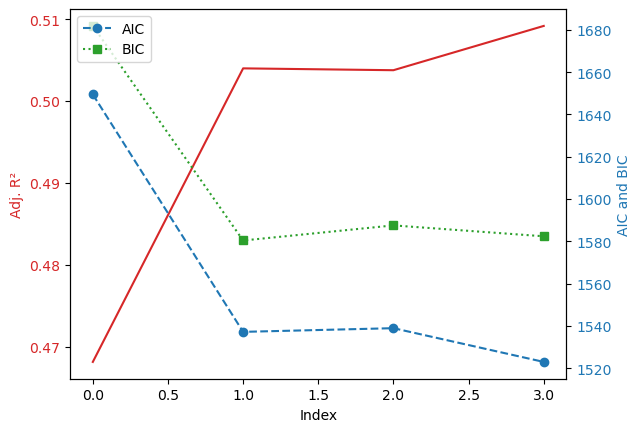

In [99]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot Adj. R² on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Index')
ax1.set_ylabel('Adj. R²', color=color)
ax1.plot(df_stats.index, df_stats['Adj. R²'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for AIC and BIC
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AIC and BIC', color=color)
ax2.plot(df_stats.index, df_stats['AIC'], color=color, marker='o', linestyle='--', label='AIC')
ax2.plot(df_stats.index, df_stats['BIC'], color='tab:green', marker='s', linestyle=':', label='BIC')
ax2.tick_params(axis='y', labelcolor=color)

# Set the legend
ax2.legend(loc='upper left')

# Display the plot
plt.show()


In [100]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf

def evaluate_model(model_string, data):
    y_names = model_string.split("~")[0].strip()
    x_names = model_string.split("~")[1].split("+")
    x_names = [name.strip() for name in x_names if name.strip()]
    
    # Extract features for the model
    X = data[x_names]
    y = data[y_names]
    
    # Initialize lists to store the RMSE for each fold
    ols_rmse_values = []
    lasso_rmse_values = []
    ridge_rmse_values = []
    
    # Define the number of folds for cross-validation
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the OLS model on the training set
        ols_model = smf.ols(formula=model_string, data=pd.concat([y_train, X_train], axis=1)).fit()
        ols_predictions = ols_model.predict(X_test)
        ols_rmse = np.sqrt(mean_squared_error(y_test, ols_predictions))
        ols_rmse_values.append(ols_rmse)
        
        # Fit the LASSO model on the training set
        # Note: You need to convert the data to a format compatible with sklearn for LASSO and Ridge
        from sklearn.linear_model import Lasso
        lasso = Lasso(alpha=0.1) # Adjust alpha as needed
        lasso.fit(X_train, y_train)
        lasso_predictions = lasso.predict(X_test)
        lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
        lasso_rmse_values.append(lasso_rmse)
        
        # Fit the Ridge model on the training set
        from sklearn.linear_model import Ridge
        ridge = Ridge(alpha=0.1) # Adjust alpha as needed
        ridge.fit(X_train, y_train)
        ridge_predictions = ridge.predict(X_test)
        ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
        ridge_rmse_values.append(ridge_rmse)
    
    # Calculate the average RMSE for each model type
    ols_rmse_avg = np.mean(ols_rmse_values)
    lasso_rmse_avg = np.mean(lasso_rmse_values)
    ridge_rmse_avg = np.mean(ridge_rmse_values)
    
    # Collect stats
    stats = {
        'Model': model_string,
        'OLS Average RMSE': ols_rmse_avg,
        'LASSO Average RMSE': lasso_rmse_avg,
        'Ridge Average RMSE': ridge_rmse_avg,
    }
    
    return stats

# Assuming data is your DataFrame and it's already preprocessed
# Evaluate each model
model_stats_2 = []
for model_string in models_string_final:
    model_stats_2.append(evaluate_model(model_string, data))

# Convert to DataFrame
df_stats_2 = pd.DataFrame(model_stats_2)
print(df_stats_2)


                                               Model  OLS Average RMSE  \
0  ln_price ~ Entire_room + accommodates +minimum...          0.400126   
1  ln_price ~ Entire_room + accommodates + beds +...          0.387523   
2  ln_price ~ Entire_room + accommodates + beds +...          0.387577   
3  ln_price ~ Entire_room + accommodates + beds +...          0.386347   

   LASSO Average RMSE  Ridge Average RMSE  
0            0.434775            0.400126  
1            0.434775            0.387522  
2            0.434775            0.387576  
3            0.433243            0.386346  


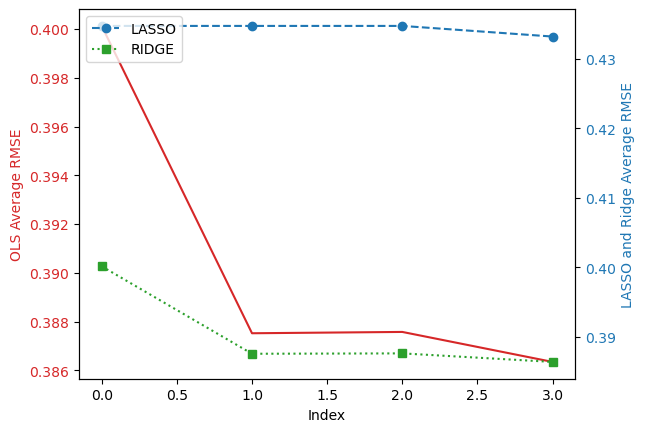

In [101]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot Adj. R² on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Index')
ax1.set_ylabel('OLS Average RMSE', color=color)
ax1.plot(df_stats_2.index, df_stats_2['OLS Average RMSE'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for AIC and BIC
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('LASSO and Ridge Average RMSE', color=color)
ax2.plot(df_stats_2.index, df_stats_2['LASSO Average RMSE'], color=color, marker='o', linestyle='--', label='LASSO')
ax2.plot(df_stats_2.index, df_stats_2['Ridge Average RMSE'], color='tab:green', marker='s', linestyle=':', label='RIDGE')
ax2.tick_params(axis='y', labelcolor=color)

# Set the legend
ax2.legend(loc='upper left')

# Display the plot
plt.show()

In [102]:

model_1 = smf.ols(formula= formula_string_4, data=data).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     170.8
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          3.22e-245
Time:                        22:57:09   Log-Likelihood:                -750.48
No. Observations:                1638   AIC:                             1523.
Df Residuals:                    1627   BIC:                             1582.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.3158      0.131     25.300      0.000       3.059       3.573
Entire_room                0.4368      0.024     18.110      0.000       0.389       0.484
accommodates               0.1148      0.011     10.083      0.000       0.092       0.137
beds                       0.0345      0.016      2.224      0.026       0.004       0.065
n_bath                     0.2504      0.025      9.891      0.000       0.201       0.300
minimum_nights            -0.0040      0.001     -4.937      0.000      -0.006      -0.002
review_scores_rating      -0.0264      0.029     -0.912      0.362      -0.083       0.030
review_scores_location     0.1118      0.035      3.188      0.001       0.043       0.181
number_of_reviews         -0.0005      0.000     -3.220      0.001      -0.001      -0.000
availability_60            0.0042      0.000      9.889      0.000       0.003       0.005
host_is_superhost          0.0034      0.023      0.150      0.881      -0.041       0.048
==============================================================================
Omnibus:                      278.219   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.631
Skew:                           0.913   Prob(JB):                    1.09e-155
Kurtosis:                       5.668   Cond. No.                         971.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Tests

## Breush Pagan Test

In [103]:
# Perform the Breusch-Pagan test
def bpTest(model):
    breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
    print("Breusch-Pagan Test:")
    print("Lagrange multiplier statistic:", breusch_pagan_test[0])
    print("p-value:", breusch_pagan_test[1])
    print("f-value:", breusch_pagan_test[2])
    print("f p-value:", breusch_pagan_test[3])

bpTest(model_1)

Breusch-Pagan Test:
Lagrange multiplier statistic: 22.041485160955727
p-value: 0.014894649238071907
f-value: 2.2192089727283
f p-value: 0.014621954716369002


In [104]:
# Change the standard errors with HC3:
model_1_hc = smf.ols(formula = formula_string_4, data=data).fit(cov_type='HC3')
model_1_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     120.3
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.70e-187
Time:                        22:57:09   Log-Likelihood:                -750.48
No. Observations:                1638   AIC:                             1523.
Df Residuals:                    1627   BIC:                             1582.
Df Model:                          10                                         
Covariance Type:                  HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.3158      0.157     21.138      0.000       3.008       3.623
Entire_room                0.4368      0.026     16.791      0.000       0.386       0.488
accommodates               0.1148      0.012      9.391      0.000       0.091       0.139
beds                       0.0345      0.017      2.059      0.039       0.002       0.067
n_bath                     0.2504      0.030      8.456      0.000       0.192       0.308
minimum_nights            -0.0040      0.001     -5.150      0.000      -0.006      -0.003
review_scores_rating      -0.0264      0.031     -0.846      0.398      -0.088       0.035
review_scores_location     0.1118      0.036      3.110      0.002       0.041       0.182
number_of_reviews         -0.0005      0.000     -2.998      0.003      -0.001      -0.000
availability_60            0.0042      0.000      9.324      0.000       0.003       0.005
host_is_superhost          0.0034      0.022      0.157      0.875      -0.039       0.046
==============================================================================
Omnibus:                      278.219   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.631
Skew:                           0.913   Prob(JB):                    1.09e-155
Kurtosis:                       5.668   Cond. No.                         971.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## VIF Test

In [105]:
def calculate_vif(data, formula_string):
    # Create design matrices
    y, X = dmatrices(formula_string, data=data, return_type='dataframe')

    # Calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data['VIF < 5'] = vif_data['VIF'].apply(lambda x: x < 5)

    return vif_data

display(calculate_vif(data, formula_string_4))


,Variable,VIF,VIF < 5
0,Intercept,190.914341,False
1,Entire_room,1.389336,True
2,accommodates,3.363055,True
3,beds,3.009158,True
4,n_bath,1.365122,True
5,minimum_nights,1.033101,True
6,review_scores_rating,1.990409,True
7,review_scores_location,1.939994,True
8,number_of_reviews,1.061885,True
9,availability_60,1.083247,True


In [106]:
def perform_reset_test(model, data, Q):
    # Get the predicted values and squared predicted values up to the power Q
    predicted_values = model.fittedvalues
    data['predicted_values'] = model.predict(data)
    data = data.dropna(subset=["predicted_values"])
    
    # Create a DataFrame with the squared predicted values up to the power Q
    squared_predicted_values = [predicted_values**(i+1) for i in range(Q+1)]
    auxiliary_data = pd.concat(squared_predicted_values, axis=1)
    
    # Add a constant to the auxiliary data
    auxiliary_data = sm.add_constant(auxiliary_data)
    
    # Fit the auxiliary regression
    auxiliary_model = sm.OLS(data["ln_price"].values, auxiliary_data).fit()
    
    # Perform the RESET test
    reset_test_results = auxiliary_model.f_test
    
    # Print the summary of the auxiliary model
    print(auxiliary_model.summary())
    
    # Print the RESET test p-value
    print("RESET test p-value:", reset_test_results)

perform_reset_test(model_1_hc, data, 3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     437.2
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          2.95e-256
Time:                        22:57:09   Log-Likelihood:                -742.11
No. Observations:                1638   AIC:                             1494.
Df Residuals:                    1633   BIC:                             1521.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6253     31.264      0.084      0.9

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\3461245631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_values'] = model.predict(data)


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_3428\2647644360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_ln_values'] = model_1_hc.predict(data)


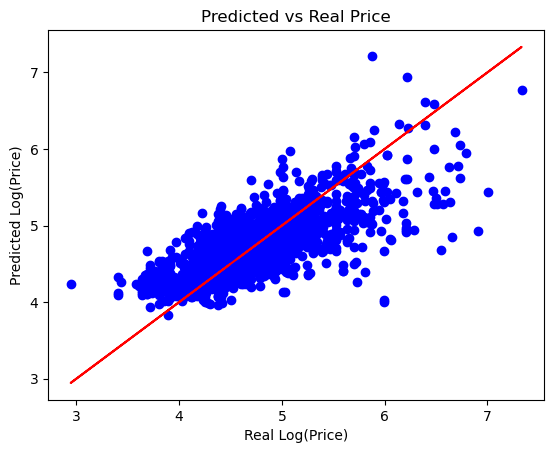

In [107]:
#plot log predicted and log real values
data['predicted_ln_values'] = model_1_hc.predict(data)
data=data.dropna(subset=["predicted_ln_values"])
data['real_ln_values'] = data['ln_price']
plt.scatter(data['real_ln_values'], data['predicted_ln_values'], color='blue')
plt.plot(data['real_ln_values'], data['real_ln_values'], color='red')
plt.xlabel('Real Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.title('Predicted vs Real Price')
plt.show()

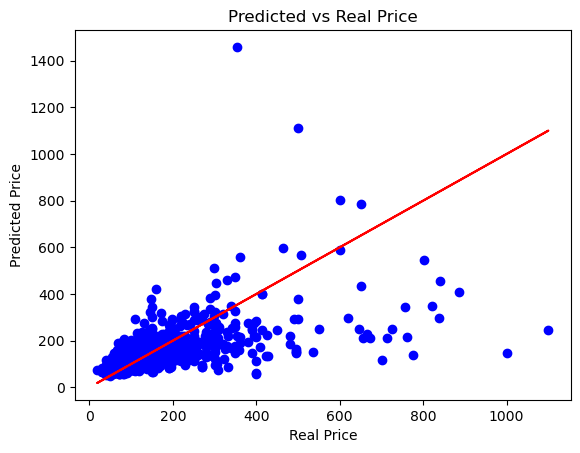

In [108]:
#plot predicted and real values

s_squared = (model_1_hc.resid**2).sum()/data.shape[0]

data['predicted_values'] = np.exp(model_1_hc.predict(data)+0.5*s_squared)
ITD = data[data['predicted_values'] > 5000].index
data.drop(ITD, inplace=True)
data=data.dropna(subset=["predicted_values"])
data['real_values'] = data['price']
ITD = data[data['real_values'] > 1200].index
data.drop(ITD, inplace=True)
plt.scatter(data['real_values'], data['predicted_values'], color='blue')
plt.plot(data['real_values'], data['real_values'], color='red')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Real Price')
plt.show()